<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/Class_balanced_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference used: https://github.com/fcakyon/balanced-loss/blob/main/balanced_loss/losses.py

In [1]:
# import argparse
import random
import copy
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.metrics as sm
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [2]:
use_cuda = torch.cuda.is_available()

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

num_classes = 10

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# load data
test_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomAffine(10, shear=10)] + test_seq
)
train_dataset = torchvision.datasets.MNIST(
    ".", train=True, download=True, transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".", train=False, transform=test_transform),
    batch_size=500,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 159676892.64it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111748795.04it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 133627502.59it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20797520.49it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 159203026.79it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111851979.52it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48308825.07it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11524820.79it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


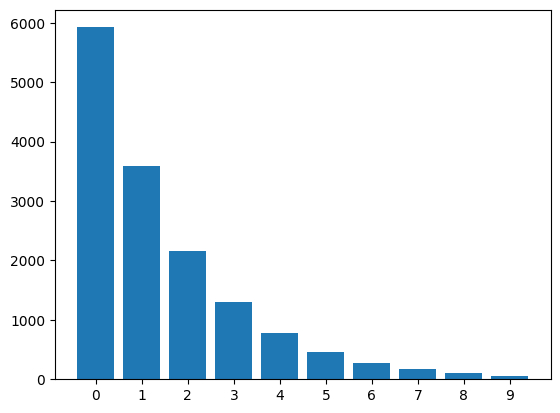

In [3]:
trainset = torchvision.datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1302,), (0.3069,)),
        ]
    ),
)


# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True
)

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


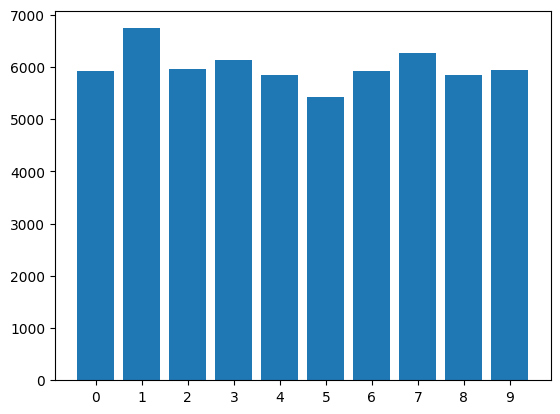

Sampling probability for each class:


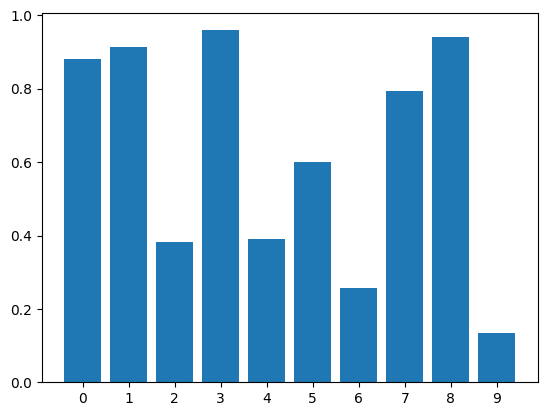

Imbalanced dataset: 14809 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


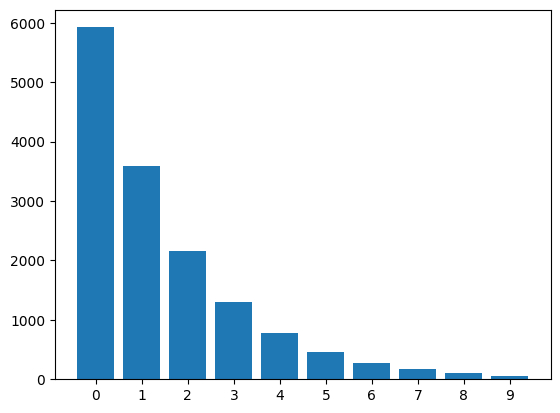

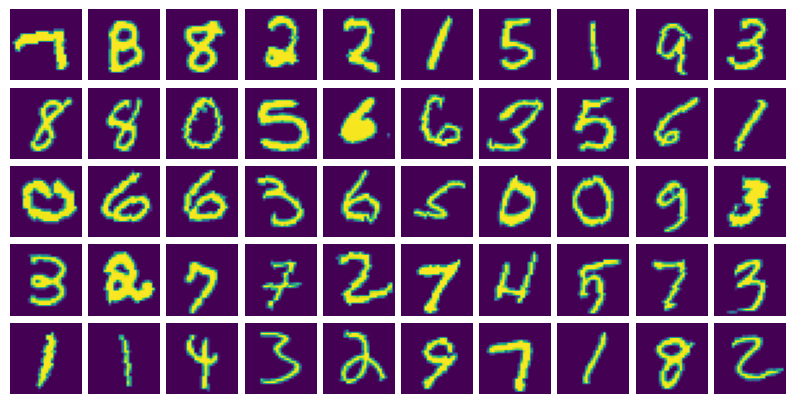

In [4]:
def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis("off")

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()


def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%" % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, "g")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", annot_kws={"size": 10})
    plt.show()
    return annot


print(
    "Original dataset: %d training samples & %d testing samples\n"
    % (len(train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print("Sampling probability for each class:")
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print(
    "Imbalanced dataset: %d training samples & %d testing samples\n"
    % (len(imbalanced_train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def process(train_loader, test_loader, lossCriterion, epochs=20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if lossCriterion == torch.nn.NLLLoss:
        print("loss is torch.nn.NLLLoss")
        criterion = lossCriterion()
    else:
        print(sorted(dict(Counter(train_loader.dataset.targets.numpy())).items()))
        num_class_list = []
        for item in sorted(dict(Counter(train_loader.dataset.targets.numpy())).items()):
            num_class_list.append(item[1])

        print("num_class_list", num_class_list)
        criterion = lossCriterion(np.array(num_class_list), 10)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(0, epochs):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

loss is torch.nn.NLLLoss
Best test acc = 48.35%
Best test acc = 63.75%
Best test acc = 69.78%
Best test acc = 71.45%
Best test acc = 73.92%
Best test acc = 75.14%
Best test acc = 76.30%
Best test acc = 77.90%
Best test acc = 80.49%
Best test acc = 80.49%
Best test acc = 81.10%
Best test acc = 82.16%
Best test acc = 83.28%
Best test acc = 85.07%
Best test acc = 87.37%
Best test acc = 87.37%
Best test acc = 87.37%
Best test acc = 87.37%
Best test acc = 87.37%
Best test acc = 87.37%


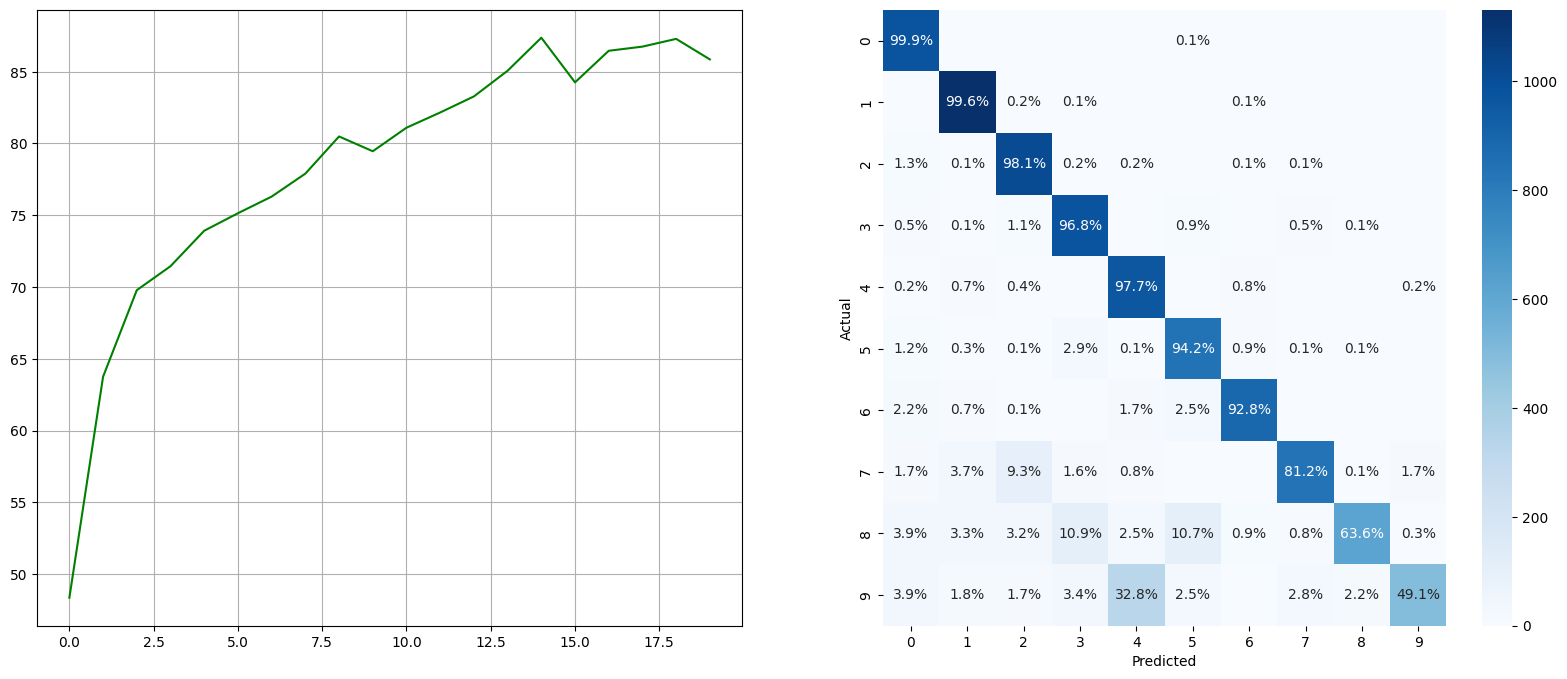

In [6]:
# baseline of torch.nn.CrossEntropyLoss
test_acc_crossentropy, confusion_mtx_crossentropy = process(
    imbalanced_train_loader, test_loader, torch.nn.NLLLoss
)

In [7]:
print(test_acc_crossentropy)
print(confusion_mtx_crossentropy)

87.37
[['99.9%' '' '' '' '' '0.1%' '' '' '' '']
 ['' '99.6%' '0.2%' '0.1%' '' '' '0.1%' '' '' '']
 ['1.3%' '0.1%' '98.1%' '0.2%' '0.2%' '' '0.1%' '0.1%' '' '']
 ['0.5%' '0.1%' '1.1%' '96.8%' '' '0.9%' '' '0.5%' '0.1%' '']
 ['0.2%' '0.7%' '0.4%' '' '97.7%' '' '0.8%' '' '' '0.2%']
 ['1.2%' '0.3%' '0.1%' '2.9%' '0.1%' '94.2%' '0.9%' '0.1%' '0.1%' '']
 ['2.2%' '0.7%' '0.1%' '' '1.7%' '2.5%' '92.8%' '' '' '']
 ['1.7%' '3.7%' '9.3%' '1.6%' '0.8%' '' '' '81.2%' '0.1%' '1.7%']
 ['3.9%' '3.3%' '3.2%' '10.9%' '2.5%' '10.7%' '0.9%' '0.8%' '63.6%'
  '0.3%']
 ['3.9%' '1.8%' '1.7%' '3.4%' '32.8%' '2.5%' '' '2.8%' '2.2%' '49.1%']]


In [8]:
class ClassBalancedCrossEntropyLoss(torch.nn.Module):
    def __init__(
        self,
        samples_per_cls,
        no_of_classes,
        beta: float = 0.9999,
        gamma: float = 2,
        reduction: str = "mean",
    ) -> None:
        super().__init__()
        self.beta = beta
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes

    def forward(self, inp: torch.Tensor, labels: torch.Tensor):
        effective_num = 1.0 - np.power(self.beta, self.samples_per_cls)
        weights = (1.0 - self.beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * self.no_of_classes

        labels_one_hot = F.one_hot(labels, self.no_of_classes).float()

        weights = torch.tensor(weights, device=device).float()
        loss = torch.nn.NLLLoss(weights)
        cb_loss = loss(inp, labels)
        return cb_loss

[(0, 5923), (1, 3596), (2, 2156), (3, 1292), (4, 774), (5, 464), (6, 278), (7, 166), (8, 100), (9, 60)]
num_class_list [5923, 3596, 2156, 1292, 774, 464, 278, 166, 100, 60]
Best test acc = 72.29%
Best test acc = 80.98%
Best test acc = 90.88%
Best test acc = 92.96%
Best test acc = 92.96%
Best test acc = 92.96%
Best test acc = 93.92%
Best test acc = 94.49%
Best test acc = 94.83%
Best test acc = 94.83%
Best test acc = 95.42%
Best test acc = 95.42%
Best test acc = 95.61%
Best test acc = 95.61%
Best test acc = 95.61%
Best test acc = 96.11%
Best test acc = 96.11%
Best test acc = 96.27%
Best test acc = 96.27%
Best test acc = 96.27%


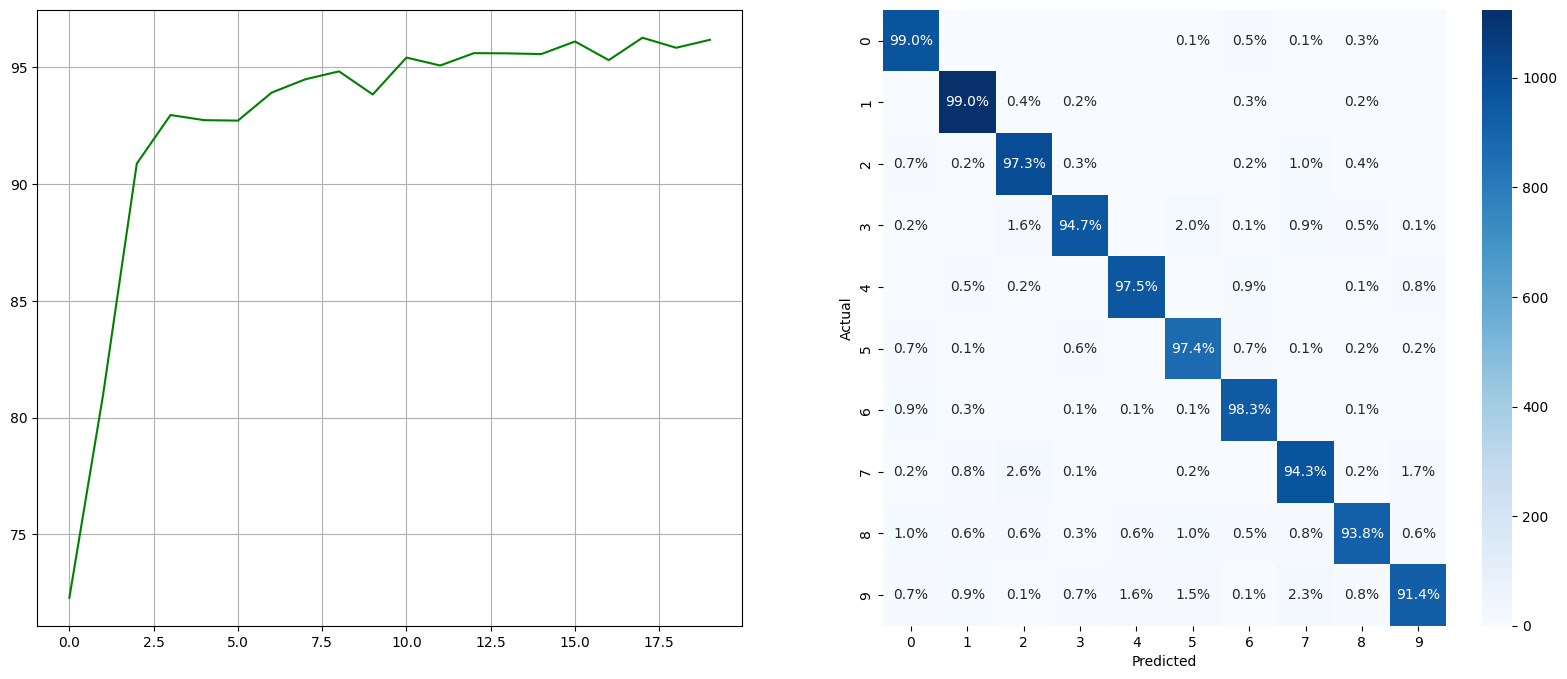

In [9]:
test_acc_ClassBalanced, confusion_mtx_ClassBalanced = process(
    imbalanced_train_loader, test_loader, ClassBalancedCrossEntropyLoss
)

In [10]:
class ClassBalancedFocalLoss(torch.nn.Module):
    def __init__(
        self,
        samples_per_cls,
        no_of_classes,
        alpha=0.98,
        beta: float = 0.9999,
        gamma: float = 2.0,
        reduction: str = "mean",
    ) -> None:
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes

    def forward(self, inp: torch.Tensor, labels: torch.Tensor):
        effective_num = 1.0 - np.power(self.beta, self.samples_per_cls)
        weights = (1.0 - self.beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * self.no_of_classes

        labels_one_hot = F.one_hot(labels, self.no_of_classes).float()

        weights = torch.tensor(weights, device=device).float()
        loss = torch.nn.NLLLoss(weights)
        ce_loss = loss(inp, labels)
        p_t = torch.exp(-ce_loss)
        cb_loss = (1 - p_t) ** self.gamma * self.alpha * ce_loss
        return cb_loss

[(0, 5923), (1, 3596), (2, 2156), (3, 1292), (4, 774), (5, 464), (6, 278), (7, 166), (8, 100), (9, 60)]
num_class_list [5923, 3596, 2156, 1292, 774, 464, 278, 166, 100, 60]
Best test acc = 75.74%
Best test acc = 81.27%
Best test acc = 88.65%
Best test acc = 88.73%
Best test acc = 90.81%
Best test acc = 91.78%
Best test acc = 92.41%
Best test acc = 93.43%
Best test acc = 93.48%
Best test acc = 93.89%
Best test acc = 93.89%
Best test acc = 93.89%
Best test acc = 94.41%
Best test acc = 94.65%
Best test acc = 94.73%
Best test acc = 94.73%
Best test acc = 94.73%
Best test acc = 94.92%
Best test acc = 94.96%
Best test acc = 95.14%


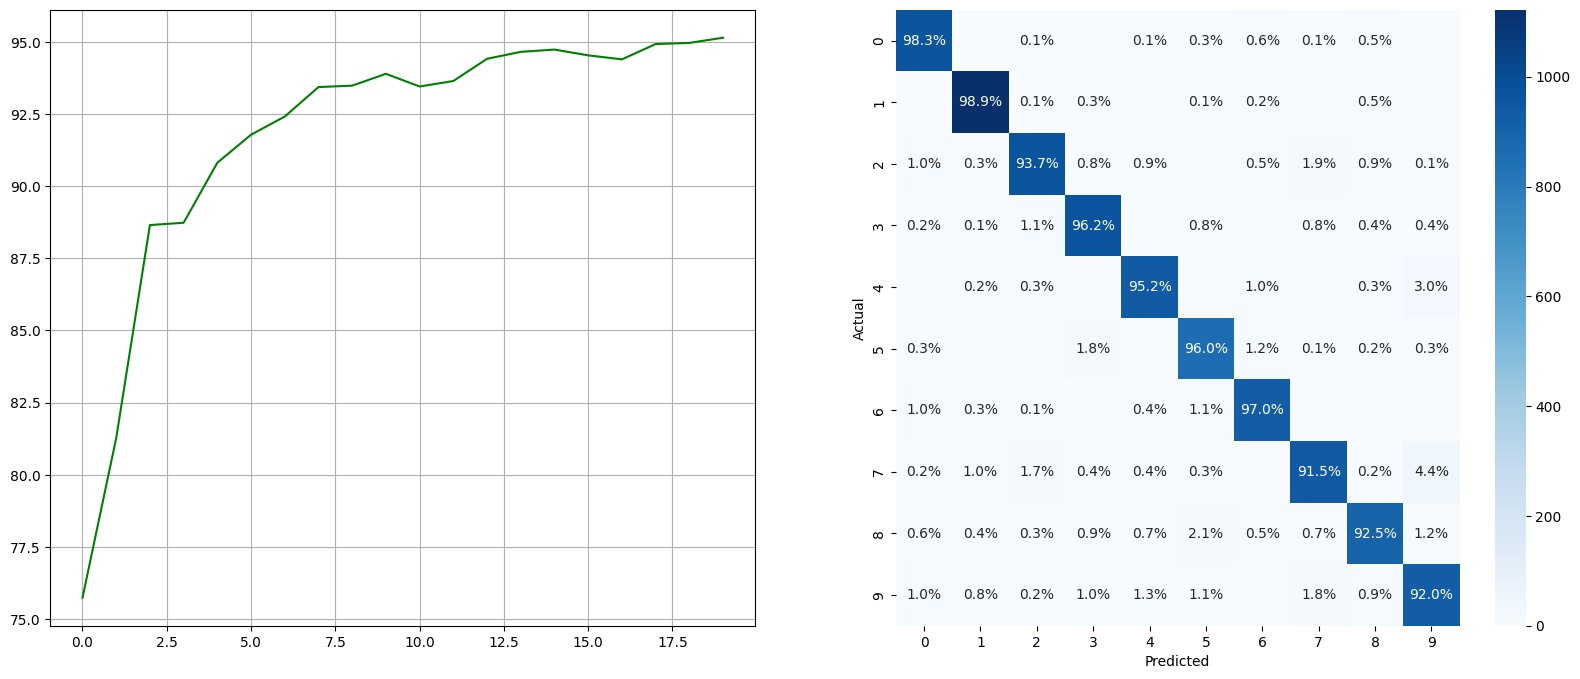

In [11]:
test_acc_ClassBalancedFL, confusion_mtx_ClassBalancedFL = process(
    imbalanced_train_loader, test_loader, ClassBalancedFocalLoss
)

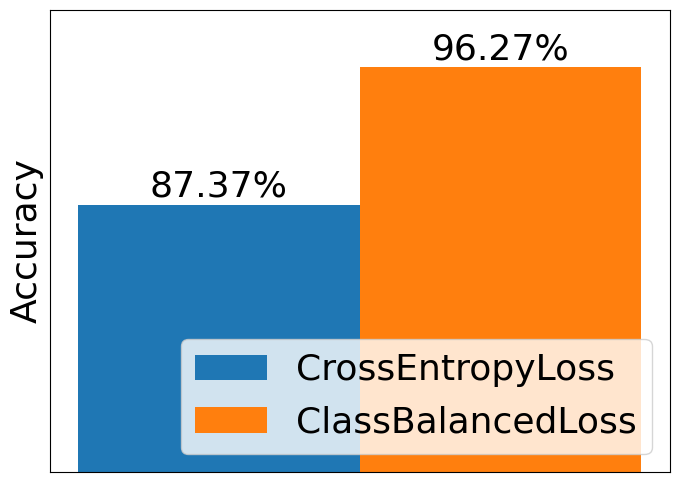

In [12]:
fig = plt.subplots(figsize=(8, 6))
plt.rcParams["font.size"] = 26

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(test_acc_crossentropy).astype(float),
    width=0.1,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(test_acc_ClassBalanced).astype(float),
    width=0.1,
    label="ClassBalancedLoss",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.legend(loc="lower right")
plt.ylabel("Accuracy", fontsize=26)
plt.show()

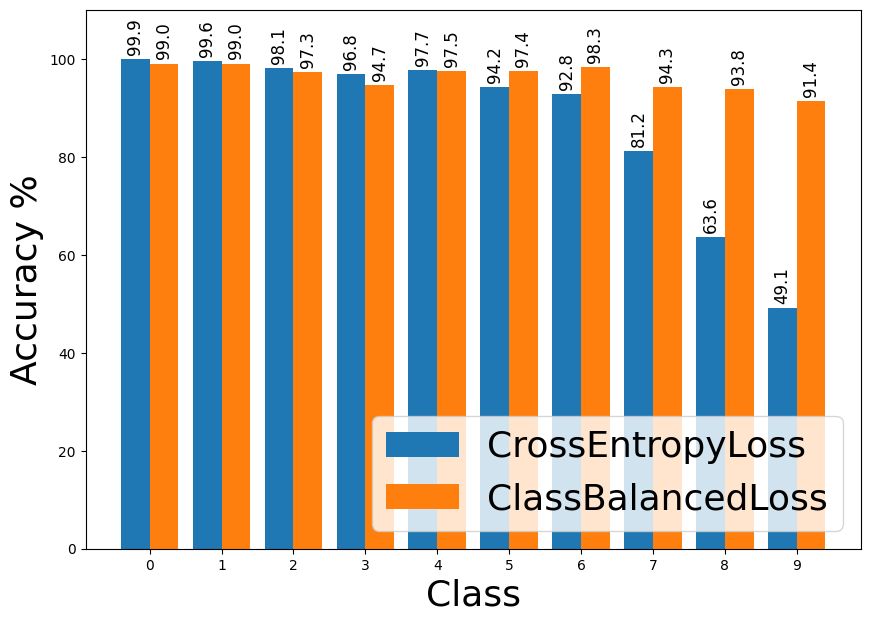

In [13]:
fig = plt.subplots(figsize=(10, 7))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages2_ClassBalanced = [
    confusion_mtx_ClassBalanced[i][i][:-1] for i in range(10)
]


p1 = plt.bar(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    width=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(class_percentages2_ClassBalanced).astype(float),
    width=0.4,
    label="ClassBalancedLoss",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )

plt.xticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.ylim(0, 110)
plt.legend(loc="lower right")
plt.xlabel("Class", fontsize=26)
plt.ylabel("Accuracy %", fontsize=26)
plt.rc("xtick", labelsize=26)
plt.rc("ytick", labelsize=26)
plt.show()

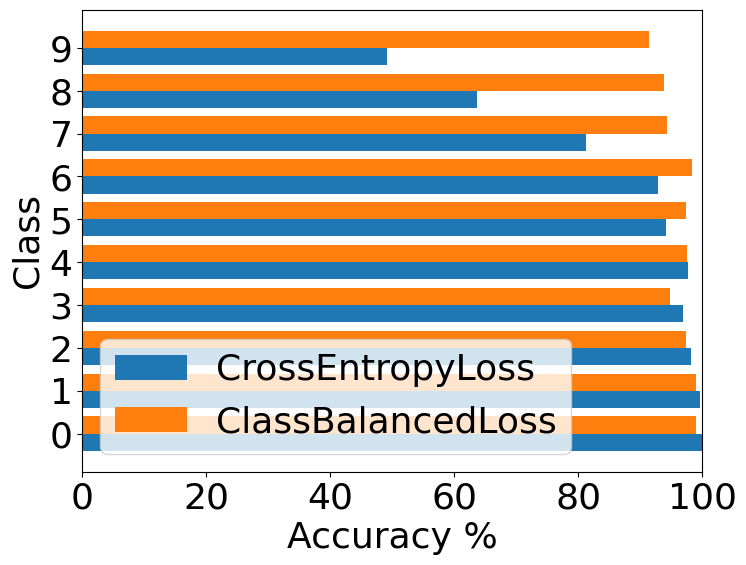

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages2_ClassBalanced = [
    confusion_mtx_ClassBalanced[i][i][:-1] for i in range(10)
]

p1 = plt.barh(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    height=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.barh(
    br2,
    np.array(class_percentages2_ClassBalanced).astype(float),
    height=0.4,
    label="ClassBalancedLoss",
)

plt.yticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.xlim(0, 100)
plt.legend(loc="lower left")
plt.ylabel("Class", fontsize=26)
plt.xlabel("Accuracy %", fontsize=26)
plt.show()

In [15]:
df = pd.DataFrame(
    {
        "CrossEntropyLoss": class_percentages_crossentropy,
        "Class-BalancedLoss": class_percentages2_ClassBalanced,
    },
    index=range(10),
)
df

,CrossEntropyLoss,Class-BalancedLoss
0,99.9,99.0
1,99.6,99.0
2,98.1,97.3
3,96.8,94.7
4,97.7,97.5
5,94.2,97.4
6,92.8,98.3
7,81.2,94.3
8,63.6,93.8
9,49.1,91.4
